# GAN 示例
本示例由[AYLIEN/gan-intro](https://github.com/AYLIEN/gan-intro/blob/master/gan.py)简化而来。

首先进行库导入和一些设置。

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class parameters():
    def __init__(self, batch_size=8, hidden_size=4, num_steps=5000, log_every=100):
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.r = 8
        self.num_points = 10000
        self.num_bins = 100
        self.num_steps = num_steps
        self.log_every = log_every

params = parameters()

seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

构建模型输入, 
- 待生成数据分布(正态分布)
- Generator输入（均匀分布白噪声）

In [2]:
def get_data(N=100, mu=4, sigma=0.5):
    return np.random.normal(mu, sigma, N)

def get_input(N=100, r=10):
    return np.linspace(-r, r, N) + np.random.random(N)*2/10/N

构建Generator、Discriminator:

利用`tf.variable_scope`来实现变量共享。

In [3]:
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

def generator(input, h_dim):
    h0 = tf.nn.softplus(linear(input, h_dim*2, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1

def discriminator(input, h_dim):
    h0 = tf.nn.relu(linear(input, h_dim*2, scope='d0'))
    h1 = tf.nn.relu(linear(h0, h_dim*2, scope='d1'))
    h2 = tf.nn.relu(linear(h1, h_dim*2, scope='d2'))
    h3 = tf.sigmoid(linear(h2, 1, scope='d3'))
    return h3

构建Optimizer:

In [4]:
def optimizer(loss, var_list):
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=var_list)
    return optimizer

def log(x):        # 防止零的情况
    return tf.log(tf.maximum(x, 1e-7))

构建GAN模型:

- 其中Discriminator构造了两个, 一个输入是真实分布, 另一个输入是Generator的输出, 省去了切换的问题。
- 利用`v.name.startswith`区分Generator和Discriminator的变量。
- 指定`var_list`实现分别训练Generator和Discriminator。

In [5]:
class GAN(object):
    def __init__(self, params):
        # True data distribution
        self.x = tf.placeholder(tf.float32, shape=(params.batch_size, 1))
        
        # Generator
        with tf.variable_scope('G'):
            self.z = tf.placeholder(tf.float32, shape=(None, 1))
            self.G = generator(self.z, params.hidden_size)
        
        # Discriminators
        with tf.variable_scope('D'):
            self.D1 = discriminator(self.x, params.hidden_size)
        with tf.variable_scope('D', reuse=True):
            self.D2 = discriminator(self.G, params.hidden_size)
        
        self.loss_g = tf.reduce_mean(-log(self.D2))
        self.loss_d = tf.reduce_mean(-log(self.D1)-log(1-self.D2))
        
        vars = tf.trainable_variables()
        self.g_vars = [v for v in vars if v.name.startswith('G/')]
        self.d_vars = [v for v in vars if v.name.startswith('D/')]
        
        self.opt_g = optimizer(self.loss_g, self.g_vars)
        self.opt_d = optimizer(self.loss_d, self.d_vars)

构建训练函数:

In [6]:
def train(model, params):
    with tf.Session() as sess:
        tf.local_variables_initializer().run()
        tf.global_variables_initializer().run()
        
        for step in range(params.num_steps+1):
            # 更新Discriminator
            x = get_data(params.batch_size)
            z = get_input(params.batch_size)
            loss_d, _ = sess.run([model.loss_d, model.opt_d], {
                        model.x: np.reshape(x, (params.batch_size, 1)), 
                        model.z: np.reshape(z, (params.batch_size, 1))
            })
            
            # 更新Generator
            z = get_input(params.batch_size)
            loss_g, _ = sess.run([model.loss_g, model.opt_g],{
                        model.z: np.reshape(z, (params.batch_size, 1))})
            
            if step % params.log_every == 0:
                print('{}: {:.4f}\t{:.4f}'.format(step, loss_g, loss_d))
                show_result(model, sess, params)

可视化训练过程:

In [7]:
def show_result(model, sess, params):
    zs = np.linspace(-params.r, params.r, params.num_points)
    bins = np.linspace(-params.r, params.r, params.num_bins)
    
    data = get_data(params.num_points)
    pd, _ = np.histogram(data, bins=bins, density=True)
    
    g = sess.run(model.G, {model.z: np.reshape(zs, (-1, 1))})
    pg, _ = np.histogram(g, bins=bins, density=True)
    
    p_x = np.linspace(-params.r, params.r, len(pd))
    f, ax = plt.subplots(1)
    ax.set_ylim(0, 1)
    plt.plot(p_x, pd, label='real data')
    plt.plot(p_x, pg, label='generated data')
    plt.title('1D Generative Adversarial Network')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

构建GAN, 训练GAN, 显示结果:

0: 1.7131	8.1338


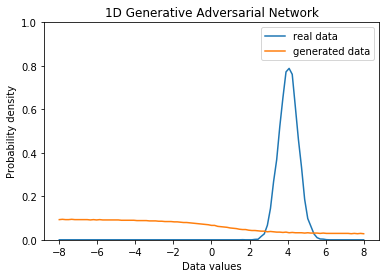

500: 0.7175	1.3710


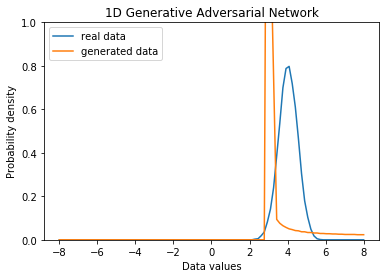

1000: 0.6930	1.3863


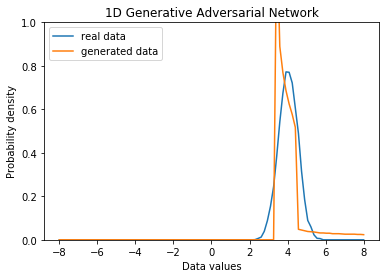

1500: 0.6931	1.3863


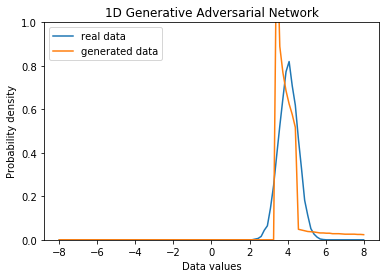

2000: 0.6931	1.3863


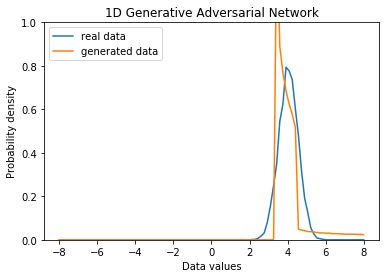

2500: 0.6931	1.3863


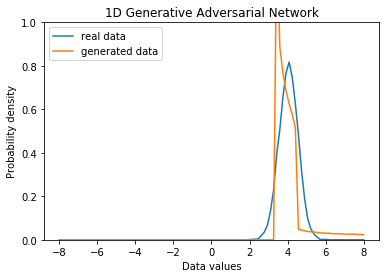

3000: 0.6931	1.3863


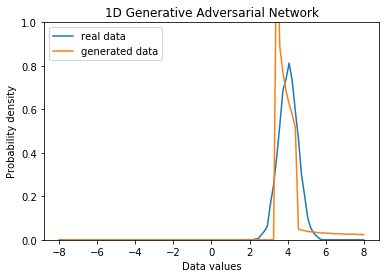

3500: 0.6931	1.3863


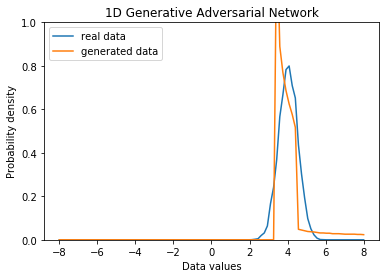

4000: 0.6931	1.3863


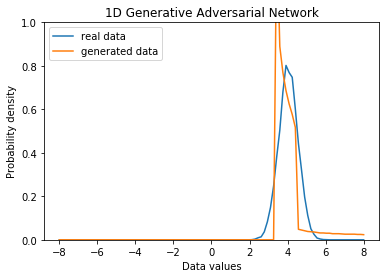

4500: 0.6931	1.3863


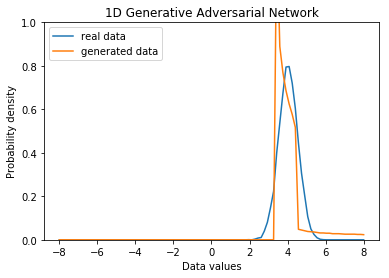

5000: 0.6931	1.3863


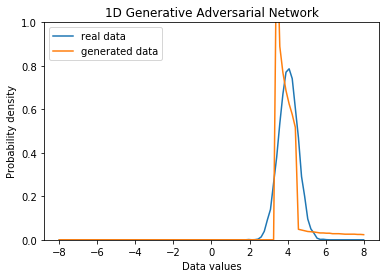

In [8]:
params = parameters(log_every=500)
model = GAN(params)
train(model, params)